# Телекоммуникации

**Цель проекта:**

Сформировать и обучить модель, которая сможет эффективно определять планирующих отказаться от услуг связи клиентов, чтобы компания могла принять меры по повышению лояльности таких клиентов и тем самым глобально уменьшить отток, а значит - повысить прибыль.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь.
- Интернет.
Также доступны такие услуги:
- Интернет-безопасность: антивирус и блокировка небезопасных сайтов
- Выделенная линия технической поддержки 
- Облачное хранилище файлов 
- Стриминговое телевидение и каталог фильмов

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

1. contract_new.csv — информация о договоре;
2. personal_new.csv — персональные данные клиента;
3. internet_new.csv — информация об интернет-услугах;
4. phone_new.csv — информация об услугах телефонии.

 Информация о договорах актуальна на 1 февраля 2020 года

**План проекта:**

 1. Загрузка и изучение данных
 2. Исследовательский анализ и предобработка данных.
Исследование данных и при необходимости выполнение предобработки. Выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
 3. Объединение данных.
Объединение выбранных признаков в один датафрейм по ключу.
 4. Исследовательский анализ и предобработка данных объединённого датафрейма.
Выполнение исследовательского анализа объединённого датафрейма, визуализирование распределения признаков и при необходимости выполнение предобработки. Проведение корреляционного анализа.
 5. Подготовка данных.
Подготовка данных для обучения модели. Разделение данных на две выборки, масштабирование и кодирование с учетом особенности данных и моделей.
 6. Обучение моделей машинного обучения.
Обучение как минимум двух моделей. Подбор как минимум двух гиперпараметров для них.
 7. Выбор лучшей модели.
Выбор лучшей модели на кросс-валидации и проверка её качества на тестовой выборке.
 8. Общий вывод и рекомендации заказчику.
Общий вывод о проделанной работе: описание основных этапов работы, полученных результатов, рекомендации для бизнеса.


## 1. Загрузка и изучение данных

In [1]:
!pip install phik

In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import phik
import category_encoders as ce
import os

from phik.report import plot_correlation_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix


import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

In [5]:
RANDOM_STATE = 201123

In [7]:
file_path = '/datasets/'
if not os.path.exists(file_path):
    file_path = '/content/'

df_contract = pd.read_csv(os.path.join(file_path, 'contract_new.csv'))
df_internet = pd.read_csv(os.path.join(file_path, 'internet_new.csv'))
df_personal = pd.read_csv(os.path.join(file_path, 'personal_new.csv'))
df_phone = pd.read_csv(os.path.join(file_path, 'phone_new.csv'))

In [8]:
def basic_info (df):
    print('Первые 5 строк:')
    display(df.head())
    print()
    print('Последние 5 строк:')
    display(df.tail())
    print()
    print('Общая информация по таблице:')
    print()
    df.info()
    print()
    print('Статистика по таблице:')
    display(df.describe())
    print()
    print('Всего явных дубликатов:', df.duplicated().sum())
    print()
    print('Количество пропусков:')
    display(df.isna().sum())
    print()


In [9]:
basic_info(df_contract)

Первые 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Последние 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Статистика по таблице:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Всего явных дубликатов: 0

Количество пропусков:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [10]:
print('Дата самого старого договора:', df_contract['BeginDate'].min())
print('Дата самого нового договора', df_contract['BeginDate'].max())

Дата самого старого договора: 2013-10-01
Дата самого нового договора 2020-02-01


In [11]:
basic_info(df_internet)

Первые 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Последние 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Статистика по таблице:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8039-EQPIM,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Всего явных дубликатов: 0

Количество пропусков:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [12]:
basic_info(df_personal)

Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Последние 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Статистика по таблице:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Всего явных дубликатов: 0

Количество пропусков:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [13]:
basic_info(df_phone)

Первые 5 строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Последние 5 строк:


,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Статистика по таблице:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2692-AQCPF,No
freq,1,3390



Всего явных дубликатов: 0

Количество пропусков:


customerID       0
MultipleLines    0
dtype: int64

### Вывод:
1. Данные представляют собой четыре таблицы с персональными данными клиентов, информацией о договорах, об интернет-услугах и услугах телефонии за период с 2013-10-01 по 2020-02-01.

2. Во всех колонках наименования нужно привести в соответствие с хорошим стилем
3. Не верный тип данных в колонках:
 -  TotalCharges - заменим на float64
 - BeginDate и EndDate  -заменим на datetime64
4. Аномалии, явные дубликаты и пропуски на данном этапе отсутствуют
5. Требуется сформировать целевой признак по колонке EndDate, а также добавить новый признак contract_period - длительность контракта
6. Колонки EndDate и BeginDate после формирования признаков удалим
7. Так же после объединения таблиц удалим колонки customerID  т к никак не влияет на исследование
8. Всего в таблицах df_personal и df_contract по 7043 строки, в таблице df_internet 5517 строк и в df_phone 6361

## Исследовательский анализ и предобработка данных.

Рассмотрим распределение целевого признака без значений No:

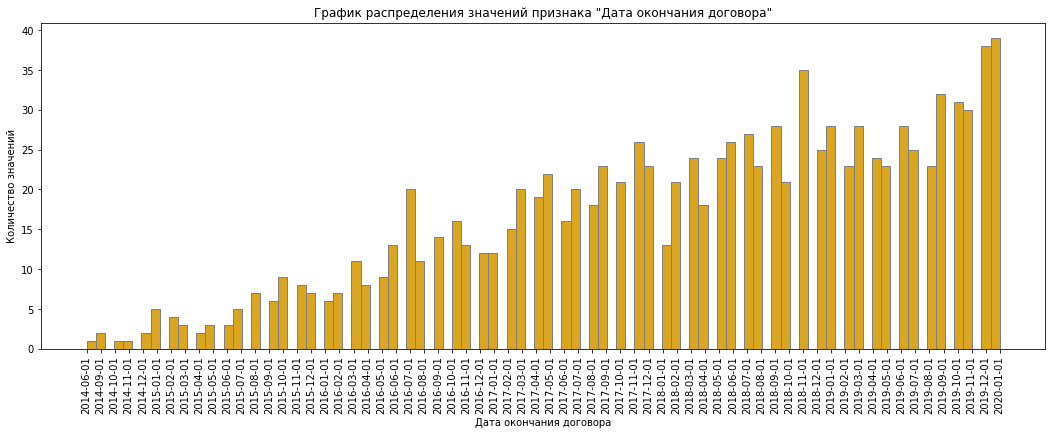

In [14]:
end = df_contract.query('EndDate != "No"').sort_values(by='EndDate')

end['EndDate'].hist(bins=100, edgecolor='Gray', figsize=(18,6), color='GoldenRod', grid=False)
plt.title('График распределения значений признака "Дата окончания договора"')
plt.xlabel('Дата окончания договора')
plt.ylabel('Количество значений')
plt.xticks(rotation='vertical')
plt.show()

In [15]:
df_contract['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2015-04-01       2
2014-11-01       1
2014-06-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

In [16]:
end['EndDate'].count().sum()

1101

На графике наблюдаем растущее колличество расторгнутых договоров от года к году, причем каждый год пиковые значения разные - сезонность не прослеживается. Такая динамика наверняка связана с увеличением числа новых договоров, т к бизнес растет и развивается - проверим в исследовании далее. В масштабе общего колличества абонентов 7043 - количество закрытых договоров - 1101, что не критично - но все же довольно значительно. 

### Формирование целевого признака

Сформируем целевой признак, значениям в колонке EndDate, содержащим дату окончания договора  присвоим 1, значениям без даты (т е тем кто не закрыл договор) присвоим 0:

In [17]:
df_contract.loc[(df_contract['EndDate'] != 'No'), 'target'] = 1
df_contract.loc[(df_contract['EndDate'] == 'No'), 'target'] = 0
df_contract['target'] = df_contract['target'].astype('int')

In [18]:
print('Целевой признак, соотношение значений:')
display(df_contract['target'].value_counts(normalize=True))

Целевой признак, соотношение значений:


0    0.843675
1    0.156325
Name: target, dtype: float64

Дисбаланс классов: 84/16 . Такое соотношение в бизнесе нормально и должно стремится к уменьшению уходящих клиентов - если бы было 50/50 это говорило бы о том что дела в компании плохи - балансировать не будем.

In [19]:
df_contract.query('BeginDate == "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


### Формирование нового признака.
Сформируем признак "contract_period" - длительность контракта, при этом заменим все значения Nо на дату 2020-02-01

In [20]:
df_contract.loc[(df_contract['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'

In [21]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'],format='%Y-%m-%d')
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format='%Y-%m-%d')

In [22]:
df_contract['contract_period'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract['contract_period'] = df_contract['contract_period'].apply(lambda x: x.days)
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,contract_period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


### Формирование датафрейма.
 Объединим все данные в одну таблицу по "customerID"

In [23]:
df = df_personal.merge(df_contract, on = 'customerID', how = 'inner')
df = df.merge(df_internet, on = 'customerID', how = 'outer')
df = df.merge(df_phone, on = 'customerID', how = 'outer')

display(df.head(5))
df.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,target,contract_period,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,0,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,0,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,0,153,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   object        
 12  target            7043 non-null   int64         
 13  contract_period   7043 non-null   int64         
 14  InternetService   5517 n

Удалим ненужные столбцы 'BeginDate', 'EndDate','customerID' 

In [24]:
df.drop(columns={'BeginDate', 'EndDate', 'customerID'}, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   object 
 9   target            7043 non-null   int64  
 10  contract_period   7043 non-null   int64  
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null   object 


Изменим тип данных в столбце TotalCharges      

Приведем названия колонок в соответствие с хорошим стилем:

In [25]:
df = df.rename(columns=str.lower)
df = df.rename(columns={'seniorcitizen' : 'senior_citizen',
                        'paperlessbilling' : 'paper_less_billing',
                        'paymentmethod' : 'payment_method',
                        'monthlycharges' : 'monthly_charges',
                        'totalcharges' : 'total_charges',
                        'internetservice' : 'internet_service',
                        'onlinesecurity' : 'online_security',
                        'onlinebackup' : 'online_backup',
                        'deviceprotection' : 'device_protection',
                        'techsupport' : 'tech_support',
                        'streamingtv' : 'streaming_tv',
                        'streamingmovies' : 'streaming_movies',
                        'multiplelines' : 'multiple_lines'})
df.columns.unique()

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'type',
       'paper_less_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'target', 'contract_period', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

### Исследовательский анализ и предобработка данных объединенного датафрейма.

In [26]:
basic_info (df)

Первые 5 строк:


,gender,senior_citizen,partner,dependents,type,paper_less_billing,payment_method,monthly_charges,total_charges,target,contract_period,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,DSL,No,Yes,No,No,No,No,NaN
1,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,DSL,Yes,Yes,No,No,No,No,No
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.5,0,153,Fiber optic,No,No,No,No,No,No,No



Последние 5 строк:


,gender,senior_citizen,partner,dependents,type,paper_less_billing,payment_method,monthly_charges,total_charges,target,contract_period,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7038,Male,0,Yes,Yes,One year,Yes,Mailed check,84.80,2035.2,0,730,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,Female,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.4,0,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.6,0,337,DSL,Yes,No,No,No,No,No,NaN
7041,Male,1,Yes,No,Month-to-month,Yes,Mailed check,74.40,520.8,0,215,Fiber optic,No,No,No,No,No,No,Yes
7042,Male,0,No,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,0,2010,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7043 non-null   object 
 1   senior_citizen      7043 non-null   int64  
 2   partner             7043 non-null   object 
 3   dependents          7043 non-null   object 
 4   type                7043 non-null   object 
 5   paper_less_billing  7043 non-null   object 
 6   payment_method      7043 non-null   object 
 7   monthly_charges     7043 non-null   float64
 8   total_charges       7043 non-null   object 
 9   target              7043 non-null   int64  
 10  contract_period     7043 non-null   int64  
 11  internet_service    5517 non-null   object 
 12  online_security     5517 non-null   object 
 13  online_backup       5517 non-null   object 
 14  device_protection   5517 non-null   object 
 15  tech_support        5517

,senior_citizen,monthly_charges,target,contract_period
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,64.761692,0.156325,898.555729
std,0.368612,30.090047,0.363189,683.130510
min,0.000000,18.250000,0.000000,0.000000
25%,0.000000,35.500000,0.000000,276.000000
50%,0.000000,70.350000,0.000000,761.000000
75%,0.000000,89.850000,0.000000,1461.000000
max,1.000000,118.750000,1.000000,2314.000000



Всего явных дубликатов: 4

Количество пропусков:


gender                   0
senior_citizen           0
partner                  0
dependents               0
type                     0
paper_less_billing       0
payment_method           0
monthly_charges          0
total_charges            0
target                   0
contract_period          0
internet_service      1526
online_security       1526
online_backup         1526
device_protection     1526
tech_support          1526
streaming_tv          1526
streaming_movies      1526
multiple_lines         682
dtype: int64

Посмотрим образовавшиеся дубликаты:

In [27]:
df[df.duplicated(keep=False)].sort_values('total_charges')

,gender,senior_citizen,partner,dependents,type,paper_less_billing,payment_method,monthly_charges,total_charges,target,contract_period,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
714,Male,0,Yes,No,Two year,No,Mailed check,25.40,1828.8,0,2191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
5024,Male,0,Yes,No,Two year,No,Mailed check,25.40,1828.8,0,2191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
542,Female,0,No,No,Month-to-month,No,Mailed check,19.55,19.55,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1491,Female,0,No,No,Month-to-month,No,Mailed check,19.55,19.55,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2121,Male,0,No,No,Month-to-month,No,Mailed check,20.45,20.45,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2892,Male,0,No,No,Month-to-month,No,Mailed check,20.45,20.45,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
437,Male,0,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8211.6,0,2191,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4797,Male,0,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8211.6,0,2191,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes


Явные дубликаты, удалим их из выборки

In [28]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Посмотрим уникальные значения категориальных признаков:

In [29]:
def unique_value(data, columns):
   
    for col in columns:
        print(f'Всего уникальных значений столбца "{col}": {data[col].nunique()}')
        print(data[col].unique())
        print(50*'_')
        print(' ')

In [30]:
unique_value(df, df.columns.drop(['monthly_charges', 'total_charges', 'contract_period']))

Всего уникальных значений столбца "gender": 2
['Female' 'Male']
__________________________________________________
 
Всего уникальных значений столбца "senior_citizen": 2
[0 1]
__________________________________________________
 
Всего уникальных значений столбца "partner": 2
['Yes' 'No']
__________________________________________________
 
Всего уникальных значений столбца "dependents": 2
['No' 'Yes']
__________________________________________________
 
Всего уникальных значений столбца "type": 3
['Month-to-month' 'One year' 'Two year']
__________________________________________________
 
Всего уникальных значений столбца "paper_less_billing": 2
['Yes' 'No']
__________________________________________________
 
Всего уникальных значений столбца "payment_method": 4
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
__________________________________________________
 
Всего уникальных значений столбца "target": 2
[0 1]
_____________________________

Посмотрим уникальные значения числовых признаков:

In [31]:
df['total_charges'].value_counts()

           11
20.45       5
101.0       5
255.0       4
21.53       4
           ..
720.65      1
2062.28     1
1477.77     1
1365.0      1
752.95      1
Name: total_charges, Length: 6658, dtype: int64

In [32]:
df['monthly_charges'].value_counts()

20.05    61
19.85    45
19.90    44
19.95    44
19.65    43
         ..
18.75     1
61.75     1
30.30     1
34.05     1
97.25     1
Name: monthly_charges, Length: 1585, dtype: int64

In [33]:
df['contract_period'].value_counts()

2191    263
153     249
92      243
123     236
31      234
       ... 
121       1
2253      1
424       1
1309      1
547       1
Name: contract_period, Length: 251, dtype: int64

Нужно заполнить пустые строки в колонке total_charges, т к это по сути пропуски и они повляют на исследования и могут спровоцировать ошибки при обучении моделей. Это новые клиенты, у которых пока нет общей суммы расходов, так что удалять их не будем.

In [34]:
df['total_charges'].value_counts()

           11
20.45       5
101.0       5
255.0       4
21.53       4
           ..
720.65      1
2062.28     1
1477.77     1
1365.0      1
752.95      1
Name: total_charges, Length: 6658, dtype: int64

In [35]:
df['total_charges'] = df['total_charges'].replace(' ', np.nan).fillna(0)
df['total_charges'].value_counts()

0          11
101.0       5
20.45       5
732.6       4
1007.5      4
           ..
2062.28     1
1477.77     1
1365.0      1
2150.7      1
752.95      1
Name: total_charges, Length: 6658, dtype: int64

In [36]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

Посмотрим распределения значений числовых признаков:

In [37]:
def distribution_value(data, name_columns):
    data.hist(bins=100, edgecolor='Gray', figsize=(18,6), color='GoldenRod')
    plt.title(f'График распределения значений признака {name_columns}')
    plt.xlabel(f'Признак {name_columns}')
    plt.ylabel('Количество значений')
    plt.show()

count    7039.000000
mean      898.435005
std       682.820576
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: contract_period, dtype: float64

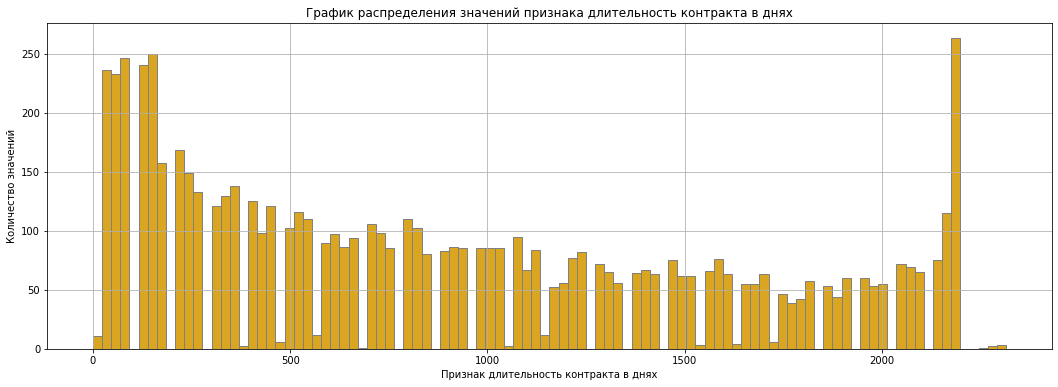

In [38]:
display(df['contract_period'].describe())
distribution_value(df['contract_period'], 'длительность контракта в днях')

count    7039.000000
mean       64.773000
std        30.079738
min        18.250000
25%        35.550000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

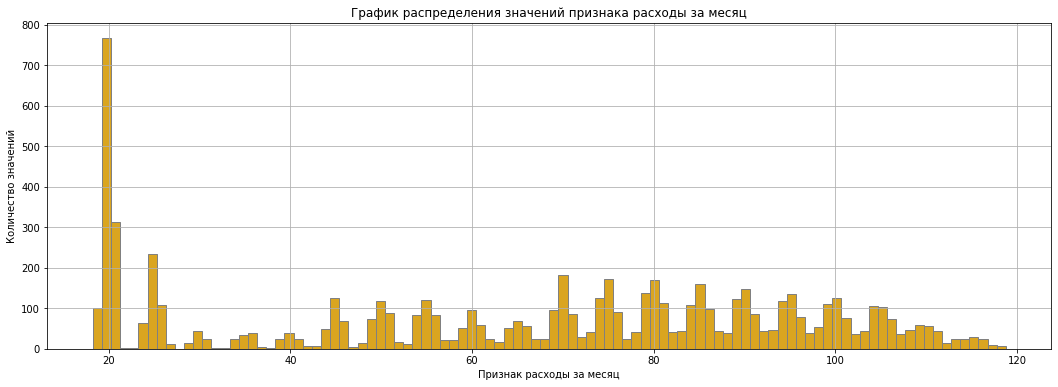

In [39]:
display(df['monthly_charges'].describe())
distribution_value(df['monthly_charges'], 'расходы за месяц')

count    7039.000000
mean     2115.082860
std      2111.795254
min         0.000000
25%       437.500000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

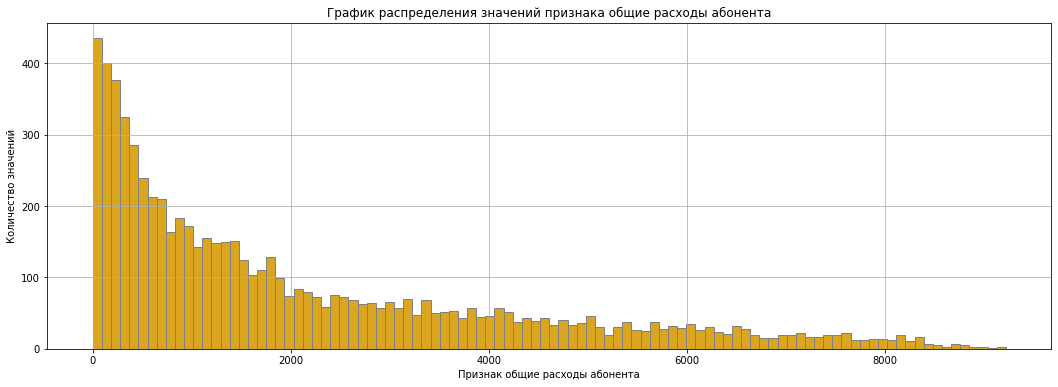

In [40]:
display(df['total_charges'].describe())
distribution_value(df['total_charges'], 'общие расходы абонента')


1. График распределения длительности контракта показывает два пиковых значения - около полугода - обусловленно приростом клиентов, второй пик около 5,5 лет - это самые старые клиенты ( т к у нас данные с незакрытыми контрактами были ограничены текущей датой)
2. График распределения расходов за месяц имеет много пиковых значений - основная масса в диапозоне от 35 до 90, самое большое значение 30 - видимо обусловлено базовым тарифом
3. График общих расходов ниспадающий - чем дольше клиент в компании - тем больше показатель общих расходов, основная масса значений в диапозоне от 438 - 3238

### Обработка пропусков

Так данные с пропусками являются интернет-услугами и услугами телефонии и они образовались в результате объединения датафреймов - эти пропуски говорят о том, что эти услуги не подключены абонентам (других данных и вводных по этому вопросу у нас нет). Значит корректно, в этом случае, заполнить услуги значением 'No', а пропуски в колонках "internet_service" и "multiple_lines" заполним заглушкой - not use - N/U 

In [41]:
df['internet_service'] = df['internet_service'].fillna('not_use')
df['multiple_lines'] = df['multiple_lines'].fillna('not_use')
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7039 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7039 non-null   object 
 1   senior_citizen      7039 non-null   int64  
 2   partner             7039 non-null   object 
 3   dependents          7039 non-null   object 
 4   type                7039 non-null   object 
 5   paper_less_billing  7039 non-null   object 
 6   payment_method      7039 non-null   object 
 7   monthly_charges     7039 non-null   float64
 8   total_charges       7039 non-null   float64
 9   target              7039 non-null   int64  
 10  contract_period     7039 non-null   int64  
 11  internet_service    7039 non-null   object 
 12  online_security     7039 non-null   object 
 13  online_backup       7039 non-null   object 
 14  device_protection   7039 non-null   object 
 15  tech_support        7039 non-null   object 
 16  stream

In [42]:
df['senior_citizen']. unique()

array([0, 1])

Поменяем тип на object:

In [43]:
df['senior_citizen'] = df['senior_citizen'].astype(object)

### Корреляционный анализ

Рассмотрим корреляционную матрицу phik, диапазон установим от 0 до 1

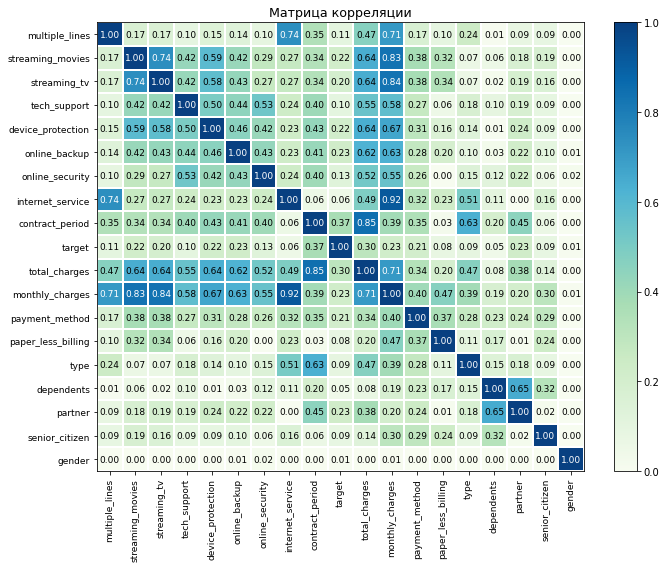

In [44]:
corr_matrix = df.phik_matrix(interval_cols=[ 'monthly_charges', 'total_charges', 'contract_period'])
corr_matrix.round(2)
plot_correlation_matrix(corr_matrix.values,
                        x_labels=corr_matrix.columns,
                        y_labels=corr_matrix.index,
                        figsize=(10, 8),
                        fontsize_factor=0.9,
                        vmin=0,
                        vmax=1,
                        color_map='GnBu',
                        title='Матрица корреляции')

Самые высокие корреляции с целевым признаком у contract_period: 0.37, total_charges: 0.30. Низкие показатели у признаков - internet_service, dependents, paper_less_billing, type, senior_citizen - у них менее 0.10. - удалять сразу не будем, проверим еще распределение зависимостей на целевом признаке. 'gender' - точно удаляем, корреляция проктически 0 - значит никак не влияет.

------------------------------------------------------------------------------------------------------------------------


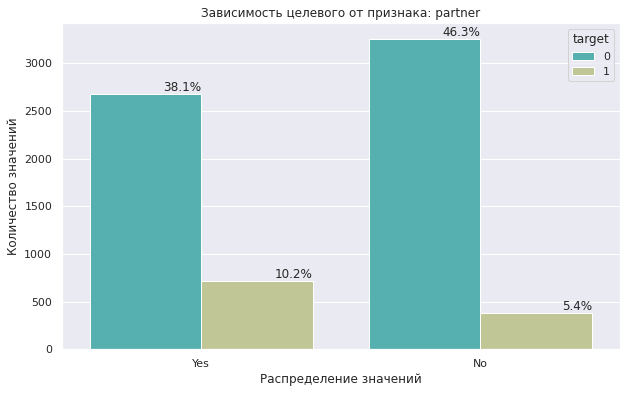

------------------------------------------------------------------------------------------------------------------------


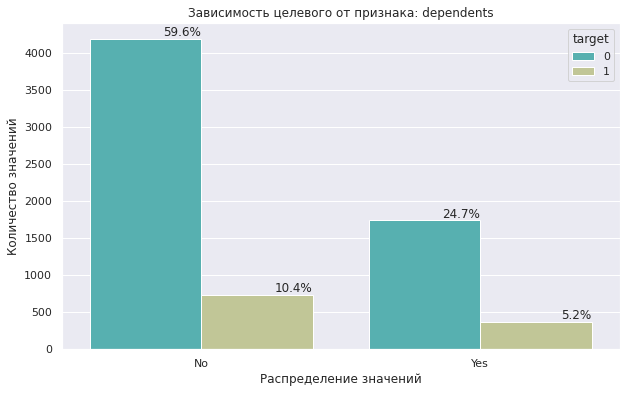

------------------------------------------------------------------------------------------------------------------------


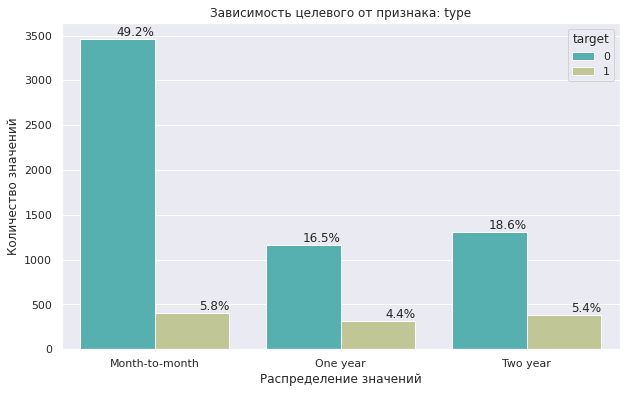

------------------------------------------------------------------------------------------------------------------------


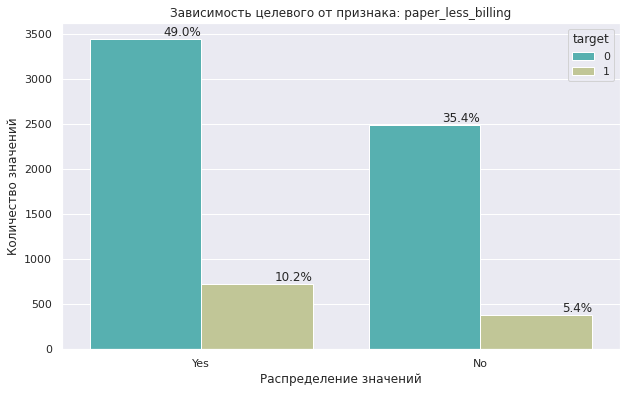

------------------------------------------------------------------------------------------------------------------------


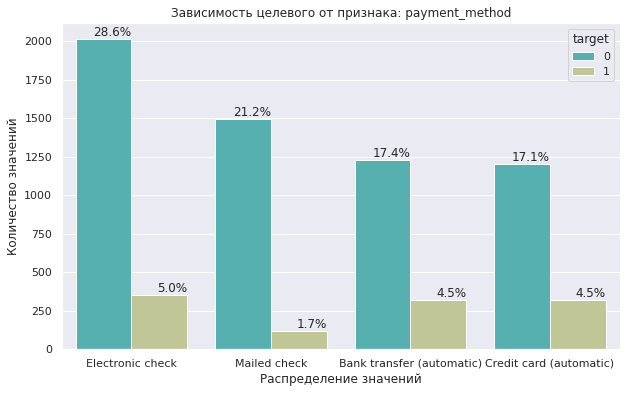

------------------------------------------------------------------------------------------------------------------------


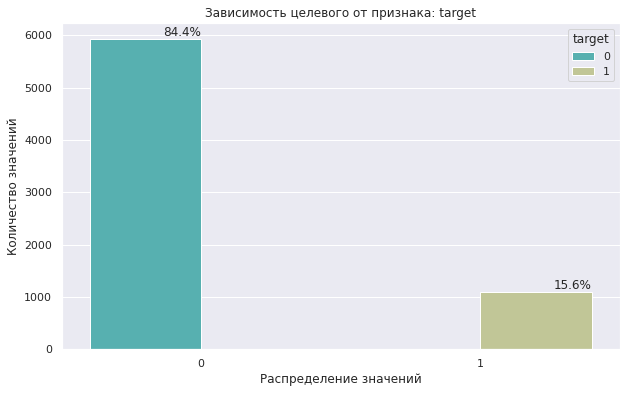

------------------------------------------------------------------------------------------------------------------------


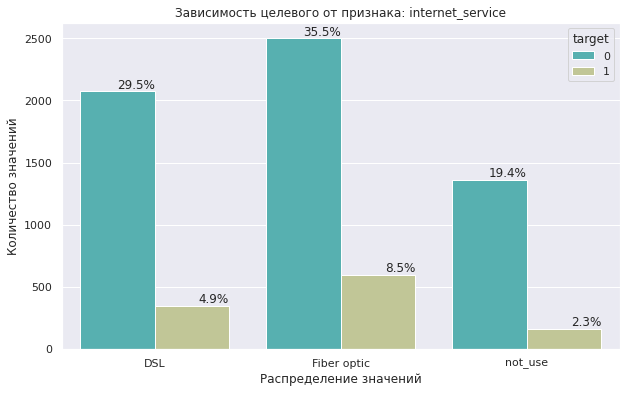

------------------------------------------------------------------------------------------------------------------------


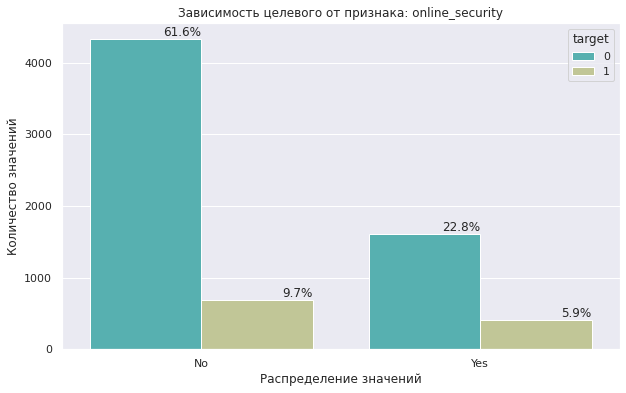

------------------------------------------------------------------------------------------------------------------------


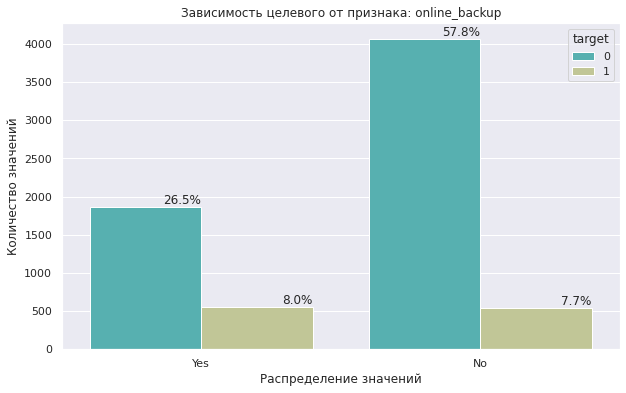

------------------------------------------------------------------------------------------------------------------------


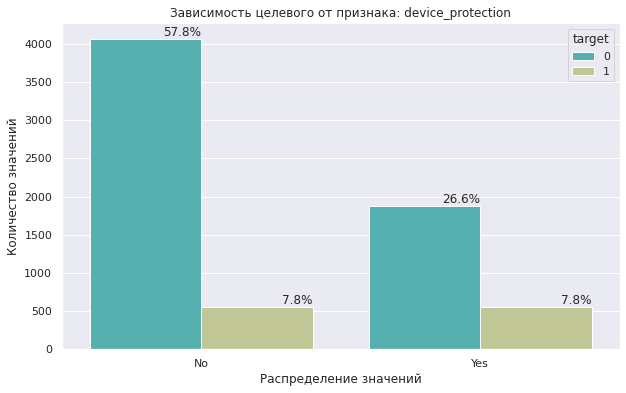

------------------------------------------------------------------------------------------------------------------------


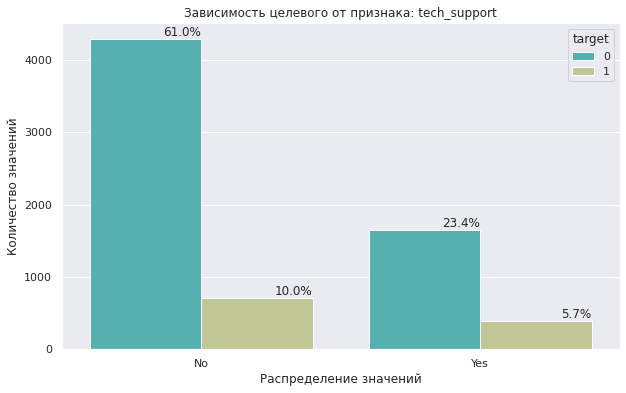

------------------------------------------------------------------------------------------------------------------------


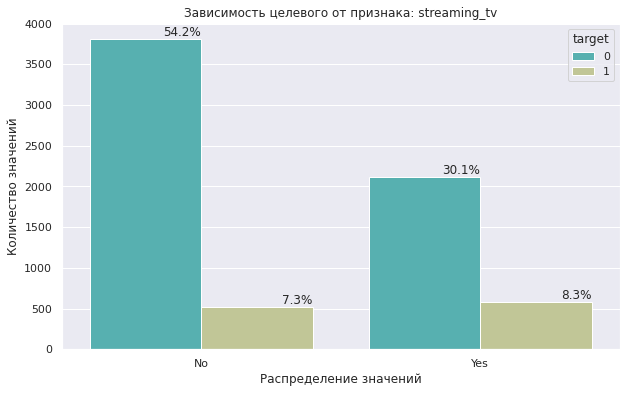

In [45]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='right', va='bottom')


def distribution_features(df, drops):
    df = df.drop([*drops], axis=1)
    col = df.columns[2:-2]
    for feature in col:
        sns.set(rc={'figure.figsize':(10,6)})
        print(120*'-')
        ax = sns.countplot(x = feature, hue='target', data=df,
                           palette='rainbow', saturation=0.5)
        for label in ax.containers:
            ax.set_title(f'Зависимость целевого от признака: {feature}')
            ax.set_xlabel('Распределение значений')
            ax.set_ylabel('Количество значений')

            without_hue(ax, df)
            plt.show()

distribution_features (df, ('monthly_charges', 'total_charges', 'contract_period'))

В признаках device_protection (антивирус) и online_backup (облачное хранилище для резервоного копирования данных) наблюдается одинаковое распределение зависимости от целевого признака и на положительном и на отрицательном значениях. Но эти признаки не будем удалять так как у них корреляция более 0.20. А вот признак type  - удалим - распределение зависимости практически одинаково и корреляция низкая

In [46]:
df.drop(columns={'type', 'gender'}, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7039 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   senior_citizen      7039 non-null   object 
 1   partner             7039 non-null   object 
 2   dependents          7039 non-null   object 
 3   paper_less_billing  7039 non-null   object 
 4   payment_method      7039 non-null   object 
 5   monthly_charges     7039 non-null   float64
 6   total_charges       7039 non-null   float64
 7   target              7039 non-null   int64  
 8   contract_period     7039 non-null   int64  
 9   internet_service    7039 non-null   object 
 10  online_security     7039 non-null   object 
 11  online_backup       7039 non-null   object 
 12  device_protection   7039 non-null   object 
 13  tech_support        7039 non-null   object 
 14  streaming_tv        7039 non-null   object 
 15  streaming_movies    7039 non-null   object 
 16  multip

#### Вывод:
1. Сформировали целевой признак по колонке EndDate
2. Рассмотрели распределения целевого признака (без значений No), наблюдаем растущее колличество расторгнутых договоров от года к году, причем каждый год пиковые значения разные - сезонность не прослеживается. Такая динамика наверняка связана с увеличением числа новых договоров, т к бизнес растет и развивается. В масштабе общего колличества абонентов 7043 - количество закрытых договоров - 1101, что не критично - но все же довольно значительно.
3. Дисбаланс классов: 84/16 . Такое соотношение в бизнесе нормально и должно стремится к уменьшению уходящих клиентов - если бы было 50/50 это говорило бы о том что дела в компании плохи - балансировать не будем. 
4. Сформировали новый признак - длительность контракта ("contract_period"), при этом заменили все значения Nо на текущую дату 2020-02-01
5. Сформировали общий датафрейм путем объединения всех таблиц
6. Привели все названия в соответствии с хорошим стилем 
7. Заполнили образовавшиеся пропуски, удалили явные дубликаты - 12 шт
8. Проверили уникальные значения признаков, распределения числовых признаков - аномалий, непрерывных данных не обнаружили
9. Исправили типы данных  
 -  TotalCharges - заменили на float64
 - BeginDate и EndDate  -заменили на datetime64
 - SeniorCitizen - заменили на object    
10. По итогам исследования удалили признаки 'BeginDate', 'EndDate', 'gender', 'customerID', 'type'
11. Всего готово к обучению 16 признаков и 7031 строк

## Подготовка данных для обучения модели.

### Деление на выборки.
Разделим данные на тренировочную и тестовую выборки в соотношении 75/25:

In [47]:
target = df['target']
features = df.drop('target', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5279, 16)
(5279,)
(1760, 16)
(1760,)


## Обучение моделей.

In [48]:
#разделим признаки на категориальные и числовые
#'type'
categories = list(features[['paper_less_billing','payment_method', 'internet_service', 
                            'online_security','streaming_tv','device_protection',
                            'streaming_movies', 'multiple_lines', 'senior_citizen',
                            'dependents','partner','tech_support','online_backup',]].columns)
numerical = list(features[['monthly_charges', 'total_charges', 'contract_period']].columns)

print(categories)
print(numerical)

['paper_less_billing', 'payment_method', 'internet_service', 'online_security', 'streaming_tv', 'device_protection', 'streaming_movies', 'multiple_lines', 'senior_citizen', 'dependents', 'partner', 'tech_support', 'online_backup']
['monthly_charges', 'total_charges', 'contract_period']


In [49]:
converted_features = [('categories', ce.glmm.GLMMEncoder(binomial_target = True), categories),
                      ('numerical', StandardScaler(), numerical)]

preprocessing = ColumnTransformer(converted_features)

### CatBoostClassifier

In [50]:
%time
model_cbc = CatBoostClassifier(early_stopping_rounds=300,  logging_level='Silent', loss_function='Logloss')

cbc_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('catboost', model_cbc)])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [51]:
parameters_cbc = {
    'catboost__max_depth': np.arange(1, 11),
    'catboost__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'catboost__iterations': [1000,1500,2000]
}

model_cbc_selection = RandomizedSearchCV(cbc_pipeline, parameters_cbc, cv=5, 
                                         scoring='roc_auc', n_jobs=-1, verbose=2, random_state=RANDOM_STATE)

In [52]:
model_cbc_selection.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=6; total time=   7.9s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=6; total time=   8.0s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=6; total time=   7.9s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=6; total time=   8.3s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=6; total time=   8.3s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=2; total time=   6.1s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=2; total time=   6.1s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_depth=2; total time=   6.3s
[CV] END catboost__iterations=1500, catboost__learning_rate=0.1, catboost__max_dept

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categories',
                                                                               GLMMEncoder(binomial_target=True),
                                                                               ['paper_less_billing',
                                                                                'payment_method',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'streaming_tv',
                                                                                'device_protection',
                                                                                'streaming_movies',
         

In [53]:
best_param_cbc = model_cbc_selection.best_params_
print('Лучшие парамеры модели CatBoostClassifier', best_param_cbc )


Лучшие парамеры модели CatBoostClassifier {'catboost__max_depth': 2, 'catboost__learning_rate': 0.1, 'catboost__iterations': 1500}


In [54]:
cbc_roc_auc = round(model_cbc_selection.best_score_, 4)
print(f"ROC AUC на модели CatBoostClassifier: {cbc_roc_auc}")

ROC AUC на модели CatBoostClassifier: 0.9127


In [55]:
best_model_cbc = model_cbc_selection.best_estimator_

### RandomForestClassifier

In [56]:
model_rfc = RandomForestClassifier()

rfc_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('randomforest', model_rfc)])

parameters_rfc = {
    'randomforest__max_depth' : np.arange (1, 8),
    'randomforest__n_estimators': (30, 300, 20)
}

In [57]:
model_rfc_selection = RandomizedSearchCV(rfc_pipeline, parameters_rfc, cv=5, 
                                         scoring='roc_auc', n_jobs=-1, verbose=2, random_state=RANDOM_STATE)
model_rfc_selection.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END randomforest__max_depth=2, randomforest__n_estimators=20; total time=   4.0s
[CV] END randomforest__max_depth=2, randomforest__n_estimators=20; total time=   4.1s
[CV] END randomforest__max_depth=2, randomforest__n_estimators=20; total time=   4.1s
[CV] END randomforest__max_depth=2, randomforest__n_estimators=20; total time=   4.0s
[CV] END randomforest__max_depth=2, randomforest__n_estimators=20; total time=   4.3s
[CV] END randomforest__max_depth=4, randomforest__n_estimators=30; total time=   4.4s
[CV] END randomforest__max_depth=4, randomforest__n_estimators=30; total time=   4.1s
[CV] END randomforest__max_depth=4, randomforest__n_estimators=30; total time=   4.1s
[CV] END randomforest__max_depth=4, randomforest__n_estimators=30; total time=   4.0s
[CV] END randomforest__max_depth=4, randomforest__n_estimators=30; total time=   4.2s
[CV] END randomforest__max_depth=2, randomforest__n_estimators=300; total time=

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categories',
                                                                               GLMMEncoder(binomial_target=True),
                                                                               ['paper_less_billing',
                                                                                'payment_method',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'streaming_tv',
                                                                                'device_protection',
                                                                                'streaming_movies',
         

In [58]:
model_rfc_selection.best_params_

{'randomforest__n_estimators': 20, 'randomforest__max_depth': 7}

In [59]:
model_rfc_best = model_rfc_selection.best_estimator_

In [60]:
rfc_roc_auc = round(model_rfc_selection.best_score_, 4)
print(f"ROC AUC на модели RandomForestClassifier: {rfc_roc_auc}")

ROC AUC на модели RandomForestClassifier: 0.7999


### GaussianNB

In [61]:
%time

model_gnb = GaussianNB(priors=None)

gnb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('gaussianNB', model_gnb)])


parameters_gnb  = {
    'gaussianNB__var_smoothing': [0.00000001, 0.000000001, 0.0000000001]
}

model_gnb_selection = RandomizedSearchCV(gnb_pipeline, parameters_gnb, cv=5, 
                                         scoring='roc_auc', n_jobs=-1, verbose=2, random_state=RANDOM_STATE)
model_gnb_selection.fit(features_train, target_train)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................gaussianNB__var_smoothing=1e-08; total time=   4.0s
[CV] END ....................gaussianNB__var_smoothing=1e-08; total time=   4.1s
[CV] END ....................gaussianNB__var_smoothing=1e-08; total time=   4.0s
[CV] END ....................gaussianNB__var_smoothing=1e-08; total time=   4.0s
[CV] END ....................gaussianNB__var_smoothing=1e-08; total time=   4.2s
[CV] END ....................gaussianNB__var_smoothing=1e-09; total time=   4.0s
[CV] END ....................gaussianNB__var_smoothing=1e-09; total time=   4.2s
[CV] END ....................gaussianNB__var_smoothing=1e-09; total time=   3.9s
[CV] END ....................gaussianNB__var_smoothing=1e-09; total time=   3.9s
[CV] END ....................gaussianNB__var_smoothing=1e-09; total time=   4.1s
[CV] END ....................gaussianNB__var_smoothing=1e-10; tota

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categories',
                                                                               GLMMEncoder(binomial_target=True),
                                                                               ['paper_less_billing',
                                                                                'payment_method',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'streaming_tv',
                                                                                'device_protection',
                                                                                'streaming_movies',
         

In [62]:
model_gnb_selection.best_params_

{'gaussianNB__var_smoothing': 1e-08}

In [63]:
gnb_roc_auc = round(model_gnb_selection.best_score_, 4)
print(f"ROC AUC на модели GaussianNB: {gnb_roc_auc}")

ROC AUC на модели GaussianNB: 0.7467


In [64]:
best_model_rfc = model_gnb_selection.best_estimator_

### Анализ моделей

Создадим сводную таблицу с контрольными метриками по обученым моделям:

In [65]:
models = ['CatBoostClassifier', 'RandomForestClassifier',  'GaussianNB']

df = {'ROC_AUC на модели с лучшими параметрами':[cbc_roc_auc, rfc_roc_auc ,gnb_roc_auc ]}
control_metrics = pd.DataFrame(data=df, index=models)
control_metrics


,ROC_AUC на модели с лучшими параметрами
CatBoostClassifier,0.9127
RandomForestClassifier,0.7999
GaussianNB,0.7467


Наилучший результат показала модель CatBoostClassifier с гиперпараметрами {'catboost__max_depth': 2, 'catboost__learning_rate': 0.2, 'catboost__iterations': 1000}

## Тестирование лучшей модели.

In [66]:
best_model_cbc.fit(features_train, target_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categories',
                                                  GLMMEncoder(binomial_target=True),
                                                  ['paper_less_billing',
                                                   'payment_method',
                                                   'internet_service',
                                                   'online_security',
                                                   'streaming_tv',
                                                   'device_protection',
                                                   'streaming_movies',
                                                   'multiple_lines',
                                                   'senior_citizen',
                                                   'dependents', 'partner',
                                                   'tech_support',
                                           

In [67]:
prediction_test = best_model_cbc.predict(features_test)
pred_proba = best_model_cbc.predict_proba(features_test)[:, 1]

# Вычисляем AUC-ROC на тестовом наборе данных
auc_roc = roc_auc_score(target_test, pred_proba)
accuracy = accuracy_score(target_test, prediction_test)
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 4))
print('Accuracy на тестовом наборе данных:', round(accuracy, 4))

AUC-ROC на тестовом наборе данных: 0.9371
Accuracy на тестовом наборе данных: 0.9409


Метрика Accuracy принимает на вход верные ответы и предсказания, а возвращает долю правильных ответов. В нашем случае результат 0.94 считается высоким, т е модель как-будто предсказывает достаточно точно. Но она не учитывает дисбаланс классов. 

В нашей задаче по поиску планирующих уйти клиентов классификатор, предсказывающий в основной части клиентов которые не уйдут  - будет иметь достаточно высокую accuracy просто потому, что уходящих (таргет=1) в выборке намного меньше.

Также метрика не учитывает цену ошибки на объектах разных классов. Если ошибочно предположить что клиент уйдет и компания примет меры по повышению его лояльности, то ничего критичного не случиться- компания потратит немного средств на улучшения условий договора, но если ошибочно предположить что клиент не уйдет - компания продолжит терять клиентов, что критично.

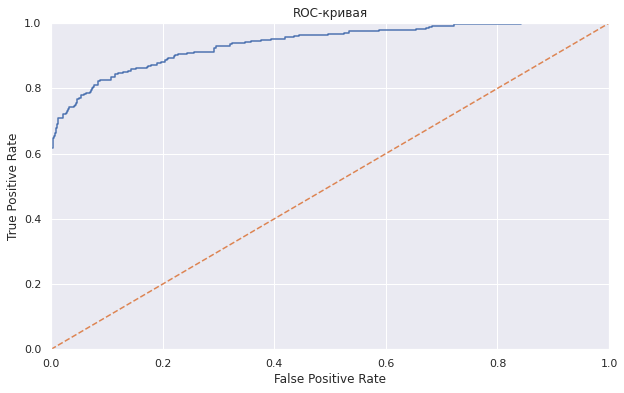

In [68]:
fpr, tpr, thresholds = roc_curve(target_test, pred_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


Чем выше площадь под кривой, тем лучше производительность модели. В нашем случае модель с очень большой вероятностью отличает один класс от другого, посмотрим еще матрицу ошибок

Матрица ошибок

Text(30.5, 0.5, 'target')

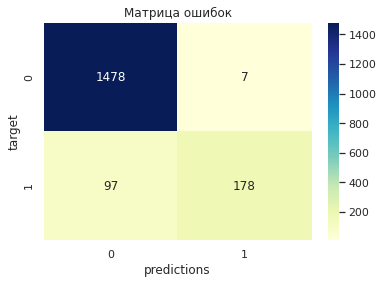

In [69]:
cbc_matrix = confusion_matrix(target_test, prediction_test)
cbc_matrix_data = pd.DataFrame(cbc_matrix,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(6, 4))
sns.heatmap(cbc_matrix,
xticklabels=cbc_matrix_data.columns,
yticklabels=cbc_matrix_data.index, annot=True, fmt='g', cmap="YlGnBu", annot_kws={"size": 12})
plt.title("Матрица ошибок")
plt.xlabel('predictions')
plt.ylabel('target')

Интерпретация результата:

По главной диагонали (от верхнего левого угла) выстроены **правильные прогнозы**:

* TN (истинно отрицательный ответ) - 1476 или 83.8% - это количество клиентов, которые по прогнозу модели не планируют уходить и фактически не ушли)
* TP (истинно положительный ответ) - 189 или 11% - это количество клиентов, которые по прогнозу модели планируют уйти и по факту ушли

Вне главной диагонали — **ошибочные варианты**:
* FP (ложноположительные ответы) - 7 или 0.4% - ошибка первого типа - это количество клиентов, которые по прогнозу модели планируют уйти, а по факту не ушли 
* FN (ложноположительные отрицательные) - 86 или 4.8%  - ошибка второго типа - это количество клиентов, которые по прогнозу модели не планируют уйти, а по факту ушли 

По матрице ошибок видим что модель ошибается в предсказании клиента, который уйдет в 87 случаях из 275 т е в 31% (ошибка второго типа). Что не очень хорошо, поскольку для бизнеса важнее правильно предсказывать именно клиентов которые закроют договор.

При этом ошибка первого типа значительно меньше и не критична - ошибочно предсказывает что клиент закроет договор в 7 случаях из 1483. Предполагаю что результат можно улучшить если увеличить выборку и добавить больше вводных данных

Выведем важность признаков для итоговой модели:

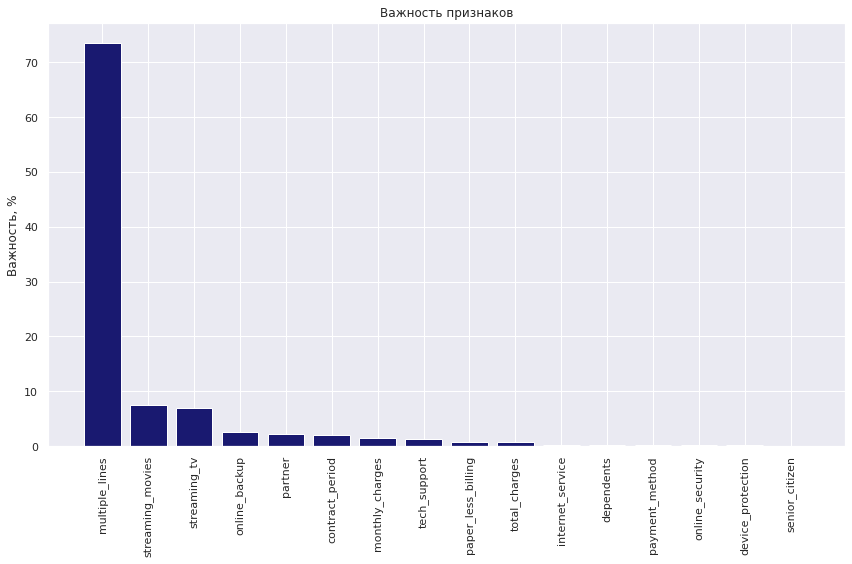

In [70]:
cbc_imp = model_cbc_selection.best_estimator_.steps[1][1].feature_importances_

importance_df = pd.DataFrame({'Features': features_train.columns,'Importance': cbc_imp})
importance_df = importance_df.sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(importance_df['Features'], importance_df['Importance'], color = 'MidnightBlue')
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
ax.set_xticklabels(importance_df['Features'], rotation=90)
fig.tight_layout()
plt.show()




Наиболее важные признаки влияющие на прогноз:

* MultipleLines — подключение телефона к нескольким линиям одновременно
* StreamingMovies — каталог фильмов
* StreamingTV — стриминговое телевидение

Влияющие в небольшой степени:
* Partner — есть ли у абонента супруг или супруга
* OnlineBackup — облачное хранилище файлов для резервного копирования данных
* contract_period - длительность контракта
* MonthlyCharges — расходы за месяц
* TechSupport — выделенная линия технической поддержки

Практические не важны:
* TotalCharges — общие расходы абонента
* PaperlessBilling — электронный расчётный лист
* Dependents — есть ли у абонента дети.


Проверим адекватность модели на DummyClassifier

In [71]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)

probabilities_test = dummy_model.predict_proba(features_test)

probabilities_one_test = probabilities_test[:, 1]
auc_roc_dummy_test = roc_auc_score (target_test, probabilities_one_test) 
        
print('roc_auc дамми-модели:',round(auc_roc_dummy_test, 4))

roc_auc дамми-модели: 0.5


roc_auc дамми-модели: 0.5 - говорит нам об адекватности выбраной нами лучшей модели, т к у нее показатель roc_auc несравнимо выше

## Итоговый вывод:
1. Данные представляют собой четыре таблицы с персональными данными клиентов, информацией о договорах, об интернет-услугах и услугах телефонии за период с 2013-10-01 по 2020-02-01.
2. Всего в таблицах df_personal и df_contract по 7043 строки, в таблице df_internet 5517 строк и в df_phone 6361
3. Сформировали целевой признак по колонке EndDate
4. Рассмотрели распределения целевого признака (без значений No), наблюдаем растущее колличество расторгнутых договоров от года к году, причем каждый год пиковые значения разные - сезонность не прослеживается. Такая динамика наверняка связана с увеличением числа новых договоров, т к бизнес растет и развивается. В масштабе общего колличества абонентов 7043 - количество закрытых договоров - 1101, что не критично - но все же довольно значительно.
5. Дисбаланс классов: 84/16 . Такое соотношение в бизнесе нормально и должно стремится к уменьшению уходящих клиентов - если бы было 50/50 это говорило бы о том что дела в компании плохи - балансировать не будем. 
6. Сформировали новый признак - длительность контракта ("contract_period"), при этом заменили все значения Nо на текущую дату 2020-02-01
7. Сформировали общий датафрейм путем объединения всех таблиц
8. Привели все названия в соответствии с хорошим стилем 
9. Заполнили образовавшиеся пропуски, удалили явные дубликаты - 12 шт
10. Проверили уникальные значения признаков, распределения числовых признаков - аномалий, непрерывных данных не обнаружили
11. Исправили типы данных  
 -  TotalCharges - заменили на float64
 - BeginDate и EndDate  - заменили на datetime64
 -  SeniorCitizen - заменили на object
12. По итогам исследования удалили признаки 'BeginDate', 'EndDate', 'gender', 'customerID', 'type'
13. Всего готово к обучению 16 признаков, 1 целевой признак и 7031 строк
14. Обучены модели с использованием GLMMEncoder и перебором гиперпараметров:
  * CatBoostClassifier
  * RandomForestClassifier  
  * GaussianNB
15. **Получены результаты по контрольным метрикам, модель, удовлетворяющая условию "значение метрики ROC-AUC > 0.85":**



|                    |	ROC-AUC|	Accuracy|
|---------------------|------------------------|-------------------------|
|CatBoostClassifier результат кросс-валидации|	0.91|	|
|CatBoostClassifier на тестовой выборке|	0.93|	0.94|


16. **Метрика ROC-AUC на тестовой выборке 0.93 (максимально возможное значение 1) означает что модель с очень большой вероятностью различает клиентов потенциально уходящих от тех кто не собирается уходить.**
17. **Метрика Accuracy принимает на вход верные ответы и предсказания, а возвращает долю правильных ответов.** Метрика Accuracy принимает на вход верные ответы и предсказания, а возвращает долю правильных ответов. В нашем случае результат 0.94 считается высоким, т е модель как-будто предсказывает достаточно точно. **Но эта метрика не учитывает дисбаланс классов.**
- В нашей задаче по поиску планирующих уйти клиентов классификатор, предсказывающий в основной части клиентов которые не уйдут будет иметь достаточно высокую accuracy просто потому, что уходящих (таргет=1) в выборке намного меньше.
- Также метрика не учитывает цену ошибки на объектах разных классов. Если ошибочно предположить что клиент уйдет и компания примет меры по повышению его лояльности, то ничего критичного не случиться- компания потратит немного средств на улучшения условий договора, но если ошибочно предположить что клиент не уйдет - компания продолжит терять клиентов, что критично.
- По матрице ошибок видим что модель ошибается в предсказании клиента, который закроет договор в 86 случаях из 275 т е в 31%. Что не очень хорошо, поскольку для бизнеса важнее правильно предсказывать именно клиентов которые закроют договор (ошибка второго типа).При этом ошибка первого типа значительно меньше и не критична - ошибочно предсказывает что клиент закроет договор в 7 случаях из 1483. Предполагаю что результат можно улучшить если увеличить выборку и добавить больше вводных данных - признаков.
18. **На основании контрольных показателей можно рекомендовать заказчику модель**
 * **CatBoostClassifier с гиперпараметрами ('catboost__max_depth': 2, 'catboost__learning_rate': 0.1, 'catboost__iterations': 1500)**

19. **Наиболее важные признаки влияющие на прогноз** 
 * **MultipleLines** — подключение телефона к нескольким линиям одновременно
 * **StreamingMovies** — каталог фильмов.
 * **StreamingTV** — стриминговое телевидение 

20. **Рекомендации.** Модель уже достаточно хорошо работает и полученные метрики соответствуют заданным. Прогноз можно улучшить. Рекомендую расширить признаки для более точного прогноза потенциального оттока клиентов, например добавить признаки с тарифными планами и категоризировать некоторые признаки - клиент с интернетом и/или с телефонной связью, расширить сбор информации - например учесть количество обращений в техподдержку, жалобы на качество связи и т д. Еще стоит включить в скрипт сотрудников уточнение причины ухода клиента при закрытии договора - данную статистику будет полезно проанализировать. Так же стоит учесть, что клиенты уходят к конкурентам, а значит стоит сравнить периоды в пиковые значения по закрытым договорам с акциями конкурентов в этот период, возможно стоит пересмотреть рекламные компании в эти периоды и разработать специальные предложения для конкурентного преимущества. 
